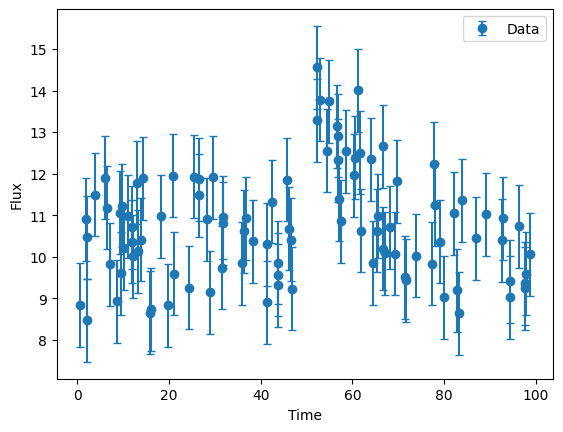

In [2]:
import numpy as np
from matplotlib import pyplot as plt

data = np.load("transient.npy")

time, flux, err = data[:,0], data[:,1], data[:,2]

plt.errorbar(time, flux, yerr=err, fmt='o', label='Data', capsize=3)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()


In [24]:
def fit_func (t, theta ):
    C, A, alpha, t0 = theta
    return np.where(t < t0,                                     # for t < t0
                    C,                                          #costant
                    C + A * np.exp(- alpha *(t - t0)))          # else , hp function


def loglikelihood (f , y , sigma):
    
    L = 1
    for i in range(len(flux)):
        L *= (1/(np.sqrt(2*np.pi) * sigma)) * np.exp(-((f[i]-y[i])/(np.sqrt(2)*sigma))**2)
    return np.log(L)


#Initial values
C0 = np.median(flux)              # bkg level
A0 = np.max(flux) - C0                           # initial amplitude
alpha0 = 0.1                      # temporal scale
t0_init = time[np.argmax(flux)]   # estimation for t0

theta0 = C0, A0 , alpha0, t0_init

print ("The log - likelihood has value: ", loglikelihood(flux, fit_func(time, theta0), err[1]))


The log - likelihood has value:  -151.1050192775015


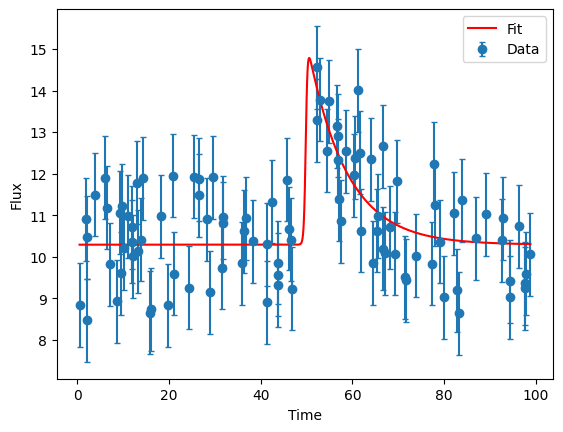

Initial values:
C0 = 10.650738, A0 = 3.907196, alpha0 = 0.100000, t0_init = 52.184832
Fitted values:
C = 10.287878, A = 5.035424, alpha = 0.118906, t0 = 49.819845


In [51]:
from scipy.optimize import curve_fit


# This function models a light curve with a smooth transition at time t0.
# For t < t0, the value is approximately constant (C).
# For t > t0, it smoothly transitions to an exponential decay: C + A * exp(-alpha * (t - t0)).
# The transition is controlled by a sigmoid (logistic function), which avoids sharp discontinuities
# and allows gradient-based fitting methods (like curve_fit) to work properly.

def fit_func2(t, C, A, alpha, t0):
    H = 1 / (1 + np.exp(-(t - t0) / 0.2))  #sigmoid function --> 0.2 is the transition width

    return C + H * A * np.exp(-alpha * (t - t0))

# Fit
popt, pcov = curve_fit(fit_func2, time, flux, sigma=err, p0=[C0, A0, alpha0, t0_init])

# best parameters
C_fit, A_fit, alpha_fit, t0_fit = popt

t_fit = np.linspace(min(time), max(time), 1000)
flux_fit = fit_func2(t_fit, *popt)

# Plot
plt.errorbar(time, flux, yerr=err, fmt='o', label='Data', capsize=2)
plt.plot(t_fit, flux_fit, label='Fit', color='red')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()

print(f"Initial values:\nC0 = {C0:.6f}, A0 = {A0:.6f}, alpha0 = {alpha0:.6f}, t0_init = {t0_init:.6f}")
print(f"Fitted values:\nC = {C_fit:.6f}, A = {A_fit:.6f}, alpha = {alpha_fit:.6f}, t0 = {t0_fit:.6f}")

In [28]:

#This represents your belief about the parameters before seeing any data.
def log_prior(theta): 
    C, A, alpha, t0 = theta
    if 0 < C < 50 and 0 < A < 50 and np.exp(-5) < alpha < np.exp(5) and 0 < t0 < 100: #task boundaries
        return np.log(1 / (50 * 50 * 100 * 10 * alpha ))
    return -np.inf  # invalid region, se sono fuori dalla regione di validità , prob = 0 , cioè - inf in log

def log_posterior(theta, time , flux , err ):
    lp = log_prior(theta)
    if not np.isfinite(lp): #isfinite = true only if it's a finite number
        return -np.inf
    return lp + loglikelihood(flux, fit_func(time, theta), err[1])

# Io definisco la likelihood del mio modello che sarebbe P(dati|theta), definisco ciò che so dei dati a priori P(theta) e definisco anche la funzione a posteriori P(theta|data)
# ora, per la statistica bayesiana : posteriori è proporzioale a likeihood per conoscenza, se la metto in log diventa che posteriori è log_like + log_conosc


In [43]:
import emcee

ndim = 4                      # number of parameters
nwalkers = 10                  # number of walkers ( 2×ndim or more)
nsteps = 80000                # number of steps per walker

# Initial positions for each walker, scattered around the initial guess
initial = np.array([C0, A0, alpha0, t0_init])
pos = initial + 1e-2 * np.random.randn(nwalkers, ndim) #this create a 8 X 4 matrix of initial guess

# Set up sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(time, flux, err))
# io non devo passare gli argomenti a log_posterior, lo fa emcee per me

# Run MCMC
sampler.run_mcmc(pos, nsteps, progress=True)



  1%|          | 726/80000 [00:03<05:15, 251.21it/s]/tmp/ipykernel_816/3768783645.py:13: RuntimeWarning: divide by zero encountered in log
  return np.log(L)
100%|██████████| 80000/80000 [06:04<00:00, 219.77it/s]


State([[10.39412817  6.72777489  0.16525539 48.44177457]
 [10.40322311  5.68724414  0.12160635 49.49281839]
 [10.26794712  5.51925925  0.13213037 49.25459708]
 [10.22199089  5.81949236  0.09735162 47.2281011 ]
 [10.30678888  3.7351646   0.09646404 51.8765373 ]
 [10.25102269 11.09716716  0.15724083 46.91391825]
 [10.22321116  3.86713708  0.12873315 51.93531066]
 [10.2667426   6.34302637  0.13914712 48.91180837]
 [10.2305474   4.38102737  0.09112448 50.07576528]
 [10.02514386  6.48979564  0.10604884 48.0055702 ]], log_prob=[-155.39802955 -154.48085217 -153.75252542 -153.51443453 -153.82565794
 -155.6722459  -153.94433803 -153.82402274 -153.85005529 -155.49393544], blobs=None, random_state=('MT19937', array([2923030769,  618826069, 3441772162,  574412725, 4129838416,
       2476197917, 2447394854, 2898951657, 3029003300, 4050460825,
       4133031034, 3162076040, 2794998971, 1934380308,  466034088,
       4139562902, 3683480233, 1652643657, 2228320045, 2333746459,
       1243166773,  2648

parametri con deviazioni all 16 perc. e 84 perc. per un'intervallo di confidenza al 90 % : 
b = 10.294 (+0.197/-0.201)
A = 5.437 (+3.408/-1.809)
alpha = 0.122 (+0.054/-0.037)
t0 = 49.097 (+2.678/-2.023)


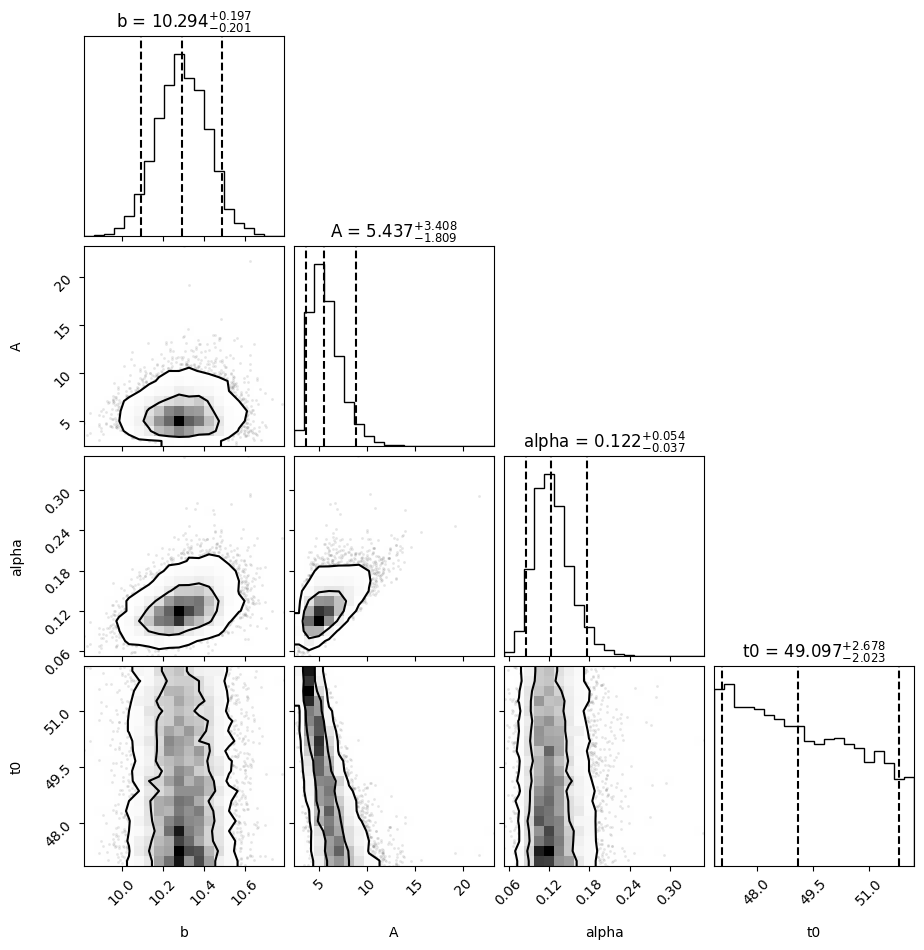

In [ ]:
import corner

burn = 5000

# Calcolo tempo di autocorrelazione e thinning
autocor_time = sampler.get_autocorr_time()
thin = int(np.mean(autocor_time))

# Ottieni campioni "piatti" (flattened) dopo burn-in e thinning
flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)

# Etichette dei parametri
labels = ["b", "A", "alpha", "t0"]

# Corner plot con i livelli di confidenza
fig_corner = corner.corner(flat_samples, labels=labels, levels=[0.68, 0.95], 
                           show_titles=True, quantiles=[0.05, 0.5, 0.95], 
                           title_fmt=".3f", title_kwargs={"fontsize": 12})

print("parametri con deviazioni all 5 perc. e 95 perc. per un'intervallo di confidenza al 90 % : ")

# Calcolo e stampa dei quantili
for i in range(flat_samples.shape[1]):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    print(f"{labels[i]} = {mcmc[1]:.3f} (+{q[1]:.3f}/-{q[0]:.3f})")

Text(0.5, 0, 'step number')

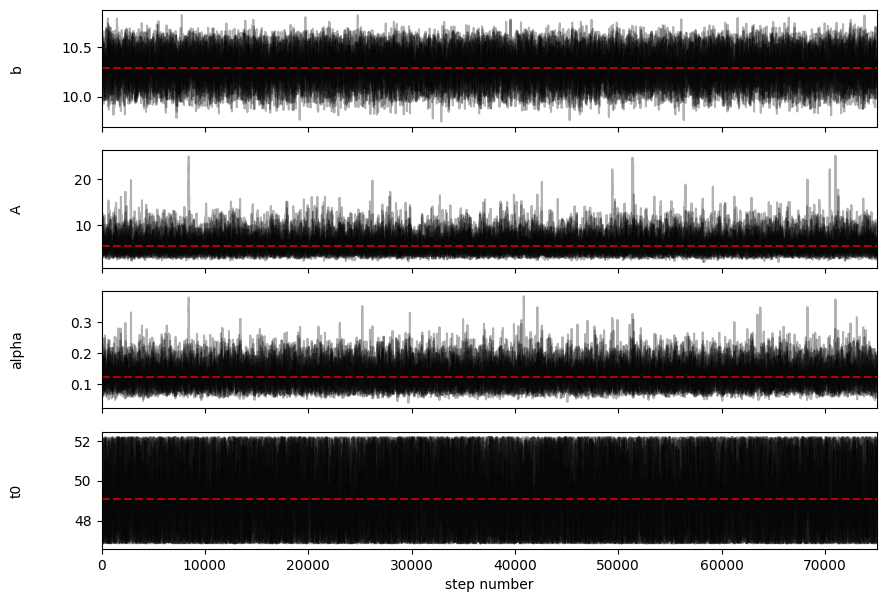

In [45]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burn) #l'ho burnata due volte? no, ma ogni volta ignoro i primi burn
labels = ["b","A", "alpha", "t0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)  #Per ogni parametro plotto l’evoluzione di tutti i walker
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    median = np.median(flat_samples[:, i])
    ax.axhline(median, color="red", linestyle="--", alpha=0.7)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

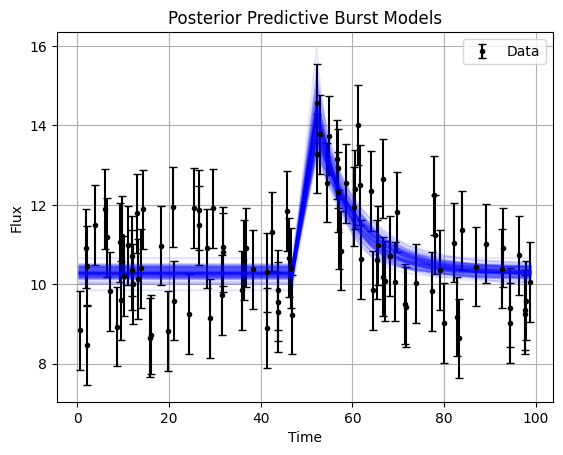

In [48]:

# Estrai 100 campioni casuali dal posteriore
idx = np.random.choice(len(flat_samples), size=100, replace=False)
sample = flat_samples[idx]

# Plot dati con errori
plt.errorbar(time, flux, yerr=err, fmt='.', color='black', label='Data', capsize=3)

# Plot dei 100 modelli generati dai parametri posteriori
for theta in sample:
    model = fit_func(time, theta)
    plt.plot(time, model, color='blue', alpha=0.1)

plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Posterior Predictive Burst Models")
plt.legend()
plt.grid(True)
plt.show()
